# Introduction

- **This is a recent project that demonstrates my technical and quantitative research skills.**
- In this notebook I process market and finacial data, and model stock returns.

## Data description

- **Market data**: assume the market data is available each day after the markets close. 
    - `openadj.csv`/`closeadj.csv`: the open/close prices adjusted for corporate actions
    - `adv.csv`: average daily volume in dollars 
    - `market_cap.csv`: total market value in million dollars
    - `sectors.csv`: the sector classification of the instruments in this universe
    - if the market cap is null for a stock for one day, the stock is out of the universe
- **Other predictors**: these have different update frequencies. Assume these predictors are available on their given date when markets open. 
    - **technical_indicator**: derived from market data
    - **holding_indicator**: the total value in dollars held by a group of institutional investors
    - **financial_indicator** 2 accounting statement items: net income and sales in million dollars 
         - net income is cumulative over the course of the fiscal year (i.e. Q3 amount is given as Q1 + Q2 + Q3)
         - the sales figure is non-cumulative
         
         
## Project Outline
- **Process the data:** identify potential data issues and clean the data accordingly 
- **Explore the data:** look at the overall distribution and time-series dynamics of the data
- **Develop a predictive model:** model future (1-day-ahead) stock returns based on all information available in the data, while prioritizing the following: 
   - avoid MARKET exposure
   - avoid SIZE exposure
   - avoid look-ahead bias.
   - don't want to be good at predicting small stocks and very bad at predicting large ones (small stocks are much more expensive to trade)
- **Conclusion:** summary of work and future ideas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import datetime
from IPython.display import HTML
from arch import arch_model
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.formula.api import wls
import multiprocessing as mp
import warnings

In [2]:
N_CORES_USE = 15
warnings.filterwarnings("ignore")

## Import data

In [7]:
'''
Raw predictors
'''
financial_indicator = pd.read_csv('./financial_indicator.csv', index_col=None, parse_dates = True)
technical_indicator = pd.read_csv('./technical_indicator.csv', index_col=0, parse_dates = True)
holding_indicator = pd.read_csv('./holding_indicator.csv', index_col=0, parse_dates = True)
financial_indicator['Date'] = pd.to_datetime(financial_indicator['Date'], format='%Y-%m-%d')
'''
Market data
'''
op = pd.read_csv('./openadj.csv', parse_dates = True, index_col=0,
                 dtype = 'float64', converters = {0: str})
cp = pd.read_csv('./closeadj.csv', index_col=0, parse_dates = True,
                 dtype = 'float64', converters = {0: str}) 
adv = pd.read_csv('./adv.csv', index_col=0, parse_dates = True,
                  dtype = 'float64', converters = {0: str})
cap = pd.read_csv('./market_cap.csv', index_col=0, parse_dates = True,
                  dtype = 'float64', converters = {0: str})
sector = pd.read_csv('./sectors.csv', index_col=0, parse_dates = True, dtype = 'str')

**All the date indices are equal in the datasets besides the financial_indicator file**

In [8]:
op.index.equals(cp.index) and op.index.equals(adv.index) \
    and op.index.equals(cap.index) and op.index.equals(sector.index) \
    and op.index.equals(technical_indicator.index) and op.index.equals(holding_indicator.index)

True

**Split the data 80-20 into training and test sets**

In [9]:
N_DATES = sector.shape[0]
TRAIN_CUTOFF = math.floor(N_DATES * .8) - 1
TRAIN_CUTOFF_DATE = sector.index[TRAIN_CUTOFF]
N_TRAIN = TRAIN_CUTOFF + 1
# the final date does not have the next days return available for comparison
N_TEST = N_DATES - TRAIN_CUTOFF - 2
NUM_STOCKS = sector.shape[1]
print("Training dates: %1d" % (N_TRAIN))
print("Testing dates: %1d" % (N_TEST))
print("Number of stocks in data: %1d" % (NUM_STOCKS))

Training dates: 2534
Testing dates: 633
Number of stocks in data: 825


### Process the financial indicator data

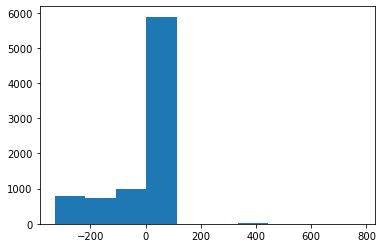

In [10]:
# merge on previous NetIncome values where available
# note that there are duplicate year-quarter pairs for some stocks
# take mean over NetIncome to handle any such duplicates
right = financial_indicator[financial_indicator.FiscalQuarter < 4] \
    [['symbol', 'FiscalQuarter', 'FiscalYear', 'NetIncome']] \
    .rename(columns = {'NetIncome': 'NetIncome_prev'})
right['FiscalQuarter'] += 1
f_ind = financial_indicator.merge(
    right.groupby(['symbol', 'FiscalYear', 'FiscalQuarter']).mean(),
    how = "left", on = ['symbol', 'FiscalYear', 'FiscalQuarter'])

# calculate non-cumulative quarterly NetIncome when data from previous quarter is available
# otherwise estimate it by dividing the cumulative NetIncome by FiscalQuarter
f_ind['inc_q'] = np.where(np.isnan(f_ind.NetIncome_prev),
                          f_ind.NetIncome / f_ind.FiscalQuarter,
                          f_ind.NetIncome - f_ind.NetIncome_prev)
f_ind.drop('NetIncome_prev', axis = 1, inplace = True)

# create absolute value with log transformation of non-cumulartive quarterly NetIncome
f_ind['inc_q_abs_lg'] = np.select(
    [
        f_ind['inc_q'] > 1, 
        f_ind['inc_q'] < -1
    ], 
    [
        np.log(f_ind['inc_q']), 
        -np.log(-f_ind['inc_q'])
    ], 
    default=0
)

# there are some -999 GrossSales values which seem like they should be treated as missing
f_ind['gross_sales_lg'] = np.where(f_ind['GrossSales'] > 0, np.log(f_ind['GrossSales']), np.nan)

# calculate number of days from the end of the quarter being reported to the report date date
quarter_dict = {1: '-03-31', 2: '-06-30', 3: '-09-30', 4: '-12-31'}
f_ind['quarter_dt'] = (np.array(financial_indicator.FiscalYear.astype(str) \
                        + np.vectorize(quarter_dict.get)(financial_indicator.FiscalQuarter))).astype('datetime64')
f_ind['days_since_qtr'] = (financial_indicator['Date'] - f_ind['quarter_dt']) / np.timedelta64(1, 'D')

# There is something weird with the dates of the statements
# and the quarters purportedly being reported on
plt.hist(f_ind['days_since_qtr'])
plt.show()

**Get the rows of the hld_ind_data with non-missing values**
- To use in the get_stock_df() function below

In [11]:
hld_ind_data = holding_indicator[NUM_STOCKS - holding_indicator.isna().sum(axis = 1) > 0]

**Note:**
- There are 999999.99 values in closing prices -- I treat these as missing and remove in the `get_stock_df` function below

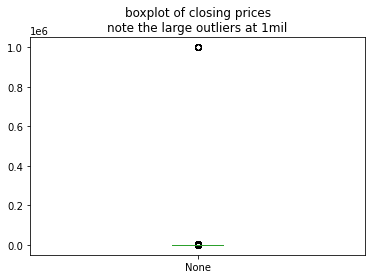

In [12]:
cp.stack().plot.box()
plt.title('boxplot of closing prices\nnote the large outliers at 1mil')
plt.show()

### Function for processing the data for each stock

In [13]:
def get_stock_df(stock_id):
    df = pd.concat([op.iloc[:,stock_id], cp.iloc[:,stock_id],
                    adv.iloc[:,stock_id], cap.iloc[:,stock_id],
                    sector.iloc[:,stock_id],
                    technical_indicator.iloc[:,stock_id]], #holding_indicator.iloc[:,stock_id]],
                   keys=['open', 'close', 'adv', 'cap', 'sector', 'tech_ind'], #'hold_ind'],
                   axis = 1)
    
    df['row_ind'] = np.arange(df.shape[0])
    df['next_open'] = df['open'].shift(-1)
    
    # calculate daily simple return
    df['ret'] = (df['close'] - df['open']) / df['open']
    # and daily log return
    df['log_ret_intraday'] = np.log(1 + df['ret'])
    
    # get prev close and calculate log return
    df['prev_close'] = df['close'].shift(1)
    df['log_ret_interday'] = np.log(df['close'] / df['prev_close'])
    
    # the next day log return is what we will want to predict
    df['next_log_ret'] = df['log_ret_intraday'].shift(-1)
    
    # remove entries with missing returns or with closing prices = 999999.99
    # also remove entries where the market cap is null because it means the stock is out of the universe
    # but not based on missing market caps in rows 3143 & 3167, where it appears erroneously missing for all stocks
    df = df.iloc[np.where((df['ret'].notnull()) & (df['close'] != 999999.99) \
                          & (df['cap'].notnull() | np.isin(df['row_ind'], [3143, 3167])))]
    
    df['stock_id'] = stock_id
    # training indicator variable
    df['train'] = df.index <= TRAIN_CUTOFF_DATE
             
    ### merge on the holding indicator data
    # based on the most recent quarterly date when holding indicator date is available
    df = pd.merge_asof(df, hld_ind_data.iloc[:,stock_id].rename('hld_ind'),
                       left_index = True, right_index = True, direction='backward')
    
    # variable equal to row index of first non-missing return in consecutive series
    df['series'] = np.where(df['row_ind'].shift(1) + 1 - df['row_ind'] == 0, np.nan, df['row_ind'])
    # copy down within series
    df['series'].ffill(inplace = True)
    # counter within series
    df['lags_avail'] = df['row_ind'] - df['series']
    
    ### deal with missing sector values
    # impute missing sector values according to the last non-missing value
    df['sector'].ffill(inplace = True)
    # sector is often also missing in first few non-missing rows -- impute forward from first non-missing value
    df['sector'].bfill(inplace = True)
    
    ### merge on financial indicator data
    # based on the most recent past date when financial statement data is available
    df = pd.merge_asof(
        df,f_ind[f_ind.symbol == stock_id].drop(['symbol', 'FiscalQuarter', 'FiscalYear', 'NetIncome'], axis = 1),
        left_index = True, right_on = 'Date', direction='backward'
    )
    df['days_from_f_ind_qtr'] = (df.index - df['quarter_dt']) / np.timedelta64(1, 'D')
    df['days_from_f_ind'] = df['days_from_f_ind_qtr'] - df['days_since_qtr']
    
    # discount the net income variable based how long since the data became available
    df['inc_q_abs_lg_adj'] = df['inc_q_abs_lg'] * np.exp(-df['days_from_f_ind'] / 50)
    
    # add aditional transformed predictor variables
    df['log_adv'] = np.log(df['adv'])
    df['log_hld'] = np.log(df['hld_ind'])
    df['log_close'] = np.log(df['close'])
    df['log_cap'] = np.log(df['cap'])
    
    df.drop(['Date', 'quarter_dt', 'days_since_qtr'], axis = 1, inplace = True)
    df['date'] = df.index
    
    return df

### Call get_stock_df for each of the 825 stocks to process all the data

In [14]:
all_stocks_df = pd.concat([get_stock_df(i) for i in range(NUM_STOCKS)], axis = 0)
all_stocks_df.set_index(['stock_id', 'date'], drop = False, inplace = True)

**Note:**
- For two days, 2022-08-05 and 2022-09-09 (last day in dataset), all market caps are null. While the instuctions suggest that all stocks are out of the universe these two days, it appears that this is not the case, and that the null values in the cap dataset those days are erroneous. So I have determined to keep the returns for these 2 dates.

In [15]:
print(cap.index[3143])
print(cap.iloc[3143].dropna().count())
print((op.iloc[3143].dropna().count(), cp.iloc[3143].dropna().count()))
print(cap.index[3167])
print(cap.iloc[3167].dropna().count())
print((op.iloc[3167].dropna().count(), cp.iloc[3167].dropna().count()))

2022-08-05 00:00:00
0
(317, 317)
2022-09-09 00:00:00
0
(316, 316)


### Create sector list and sector indicator
- **Note:** Individual stocks change sector over time

In [16]:
sectors_list = all_stocks_df['sector'].unique()
sectors_list.sort()
num_sectors = len(sectors_list)
sectors_dict = {sect: i for i, sect in enumerate(sectors_list)}
all_stocks_df['sector_id'] = np.vectorize(sectors_dict.get)(all_stocks_df['sector'])

## Clean up the data

**Take a look at the relationship between the stocks' closing price and their next day open price**

correlation between close and next open prices when close > 0: 0.99981


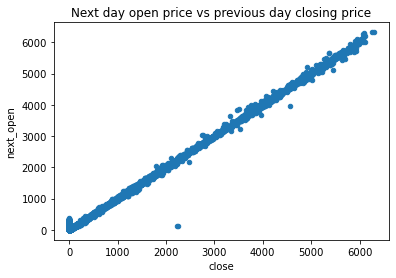

In [17]:
non_zero_close = all_stocks_df['close'] > 0
corr = all_stocks_df[non_zero_close].close.corr(all_stocks_df[non_zero_close].next_open)
print("correlation between close and next open prices when close > 0: %1.5f" % (corr))
all_stocks_df.plot.scatter('close','next_open')
plt.title('Next day open price vs previous day closing price')
plt.show()

**The situations (n = 1238) where closing prices = 0 appear anomolous / erroneous.**

- Based on the near perfect correlation (>0.999) between non-zero closing prices and next day open prices, it might be reasonable to impute zereod closing prices with the next day prices
- However, this solution is not entirely satisfactory and potentially introduces look-ahead bias
- I have decided to remove the zero close price rows from the analysis

In [18]:
zero_close = all_stocks_df[all_stocks_df['close'] == 0]
print('num of different stocks with zero close price: %d' % (len(np.unique(zero_close.stock_id))))
display(zero_close[['stock_id', 'prev_close', 'open', 'close', 'next_open']])

## remove zero close rows
all_stocks_df = all_stocks_df[all_stocks_df['close'] > 0]

num of different stocks with zero close price: 48


stock_id  prev_close       open  close  next_open
stock_id date                                                         
28       2010-05-26        28   26.071878  26.123839    0.0  26.494068
         2010-08-10        28   27.357035  27.081958    0.0  26.787233
         2011-02-09        28   32.968350  32.788595    0.0  32.755307
         2011-09-08        28   33.342849  33.274830    0.0  32.778292
         2012-02-23        28   36.880359  36.832382    0.0  36.983166
...                       ...         ...        ...    ...        ...
791      2010-08-10       791   14.720000  14.500000    0.0  14.510000
         2011-02-09       791   19.720000  19.600000    0.0  19.420000
802      2013-01-23       802   21.520000  21.650000    0.0  20.330000
         2013-03-13       802   17.040000  17.300000    0.0  17.500000
         2013-05-07       802   18.260000  18.220000    0.0  13.620000

[1238 rows x 5 columns]

**The situations where next day opening prices fall significantly from the previous day closing prices do not appear anomalous / erroneous**

In [19]:
display_cols = ['date','stock_id','prev_close','open','close','next_open']
retrict_rows = all_stocks_df.close - all_stocks_df.next_open > 500
display(HTML(all_stocks_df[retrict_rows][display_cols].to_html(index=False)))
display(HTML(all_stocks_df.shift(-1)[retrict_rows][display_cols].to_html(index=False)))

date,stock_id,prev_close,open,close,next_open
2014-11-26,471,4688.912071,4653.300081,4558.334773,3954.90938
2022-07-15,701,2207.350000,2240.010000,2235.550000,112.64000
2022-07-15,702,2228.800000,2259.260000,2255.340000,113.44000


date,stock_id,prev_close,open,close,next_open
2014-12-01,471.0,4558.334773,3954.90938,3970.736931,3917.318945
2022-07-18,701.0,2235.550000,112.64000,109.030000,110.850000
2022-07-18,702.0,2255.340000,113.44000,109.910000,111.730000


**Check boxplot of intraday log returns**

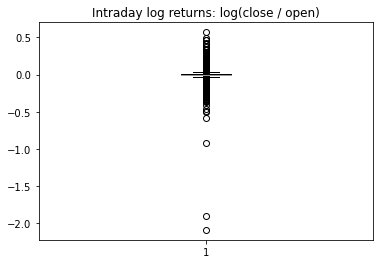

In [20]:
plt.boxplot(all_stocks_df['log_ret_intraday'])
plt.title('Intraday log returns: log(close / open)')
plt.show()

**Investigate the significant negative outliers of the log returns**

In [21]:
display_cols = ['date','stock_id','prev_close','open','close','next_open','log_ret_intraday']
retrict_rows = all_stocks_df['log_ret_intraday'] < -.75
display(HTML(all_stocks_df[retrict_rows][display_cols].to_html(index=False)))

date,stock_id,prev_close,open,close,next_open,log_ret_intraday
2011-11-29,0,1.620000,0.650000,0.260000,0.425000,-0.916291
2012-01-03,319,7.708499,56.255644,8.364542,8.364542,-1.905905
2020-03-24,351,2.700000,2.900000,0.360000,0.720000,-2.086362


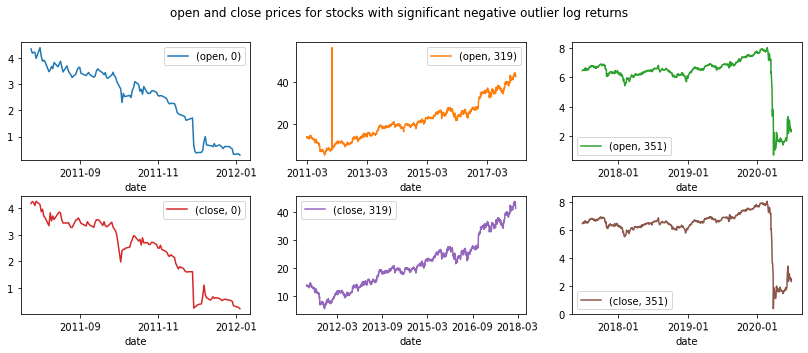

In [22]:
ids_chk = np.unique(all_stocks_df[all_stocks_df['log_ret_intraday'] < -.75]['stock_id'])
ax = all_stocks_df.loc[ids_chk][['open','close']].unstack(level=0) \
    .plot(subplots=True, rot=1, layout=(2, 3), figsize=(14, 5), sharex = False)
  
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
ax[0,1].xaxis.set_major_locator(mdates.MonthLocator(interval = 24))
ax[0,2].xaxis.set_major_locator(mdates.MonthLocator(interval = 12))
ax[1,0].xaxis.set_major_locator(mdates.MonthLocator(interval = 2))
ax[1,1].xaxis.set_major_locator(mdates.MonthLocator(interval = 18))
ax[1,2].xaxis.set_major_locator(mdates.MonthLocator(interval = 12))
plt.suptitle('open and close prices for stocks with significant negative outlier log returns')
plt.subplots_adjust(hspace=.3)
plt.show()

**One of the three outliers (stock #319, middle column) appears erroneous**
- Again it might be reasonable to replace the anamolous open price with the previous day closing price
- However, I have decided to remove the entry from the analysis

In [23]:
print(all_stocks_df.shape[0])
## remove row where stock_id = 319 and log_ret_intraday > 1.9
all_stocks_df = all_stocks_df[np.logical_not((all_stocks_df['log_ret_intraday'] < -1.9) \
                                             & (all_stocks_df['stock_id'] == 319))]
print(all_stocks_df.shape[0])

1061403
1061402


In [24]:
print("%1d log returns, %2d stocks and %3d dates" % (all_stocks_df.shape[0],
                                                     all_stocks_df.stock_id.unique().shape[0],
                                                     all_stocks_df.date.unique().shape[0]))

1061402 log returns, 825 stocks and 3168 dates


# **With the data processed and cleaned we are left with:**
- 1,061,402 returns (open / close price pairs)
- across 825 stocks and 3168 dates

### Aggregate data across sectors and overall
- calculate price weighted index returns

In [25]:
# sum open and close prices across sector and date
sector_agg = all_stocks_df.drop('date', axis = 1).groupby(['sector', 'date'])[['open','close']] \
    .agg({'open' : ['count', 'sum'], 'close' : ['sum']}) \
    .reindex(pd.MultiIndex.from_product([all_stocks_df['sector'].unique(), all_stocks_df['date'].unique()]))
sector_agg['counts'] = np.where(np.isnan(sector_agg[('open', 'count')]), 0, sector_agg[('open', 'count')])

# calculate price weighted index returns
sector_agg['ret'] = (sector_agg[('close', 'sum')] - sector_agg[('open', 'sum')]) / sector_agg[('open', 'sum')]
sector_agg.drop([('open', 'sum'), ('close', 'sum'), ('open', 'count')], axis = 1, inplace = True)
sector_agg['log_ret'] = np.log(1 + sector_agg['ret'])
sector_agg['train'] = sector_agg.index.get_level_values(1) <= TRAIN_CUTOFF_DATE
sector_agg.sort_index(inplace = True)

# sum open and close prices across date and calculate price weighted index returns
all_agg = all_stocks_df.drop('date', axis = 1).groupby(['date'])[['open','close']].sum()
all_agg.sort_index(inplace = True)
all_agg['ret'] = (all_agg['close'] - all_agg['open']) / all_agg['open']
all_agg['log_ret'] = np.log(1 + all_agg['ret'])
all_agg['train'] = all_agg.index <= TRAIN_CUTOFF_DATE
all_agg['date'] = all_agg.index

## Explore and describe the data

### Goal: design a prediction model for future stock returns based on all information given

- I will work on making predictions for intraday log returns
- Calculated as
        log_ret = log(close_price / open_price)
- log returns take real values
- normally distributed when prices are log normally distributed
- log returns depend on relative changes in price, so that working with log returns naturally helps combat SIZE exposure


### Begin by looking at the distribution of all the log returns in the training data

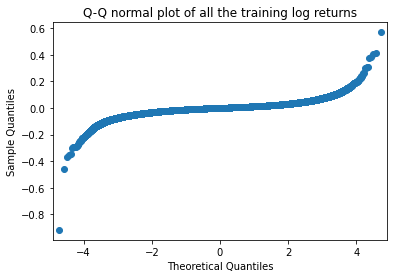

In [26]:
sm.qqplot(all_stocks_df[all_stocks_df.train]['log_ret_intraday'])
plt.title('Q-Q normal plot of all the training log returns')
plt.show()

**The Q-Q plot shows that the distribution of all the log returns has fat tails -- not normally distributed**

**Next** look at the overall aggregated returns:

Augmented Dickey-Fuller test for non-stationarity on training data: p-value = 0.00000


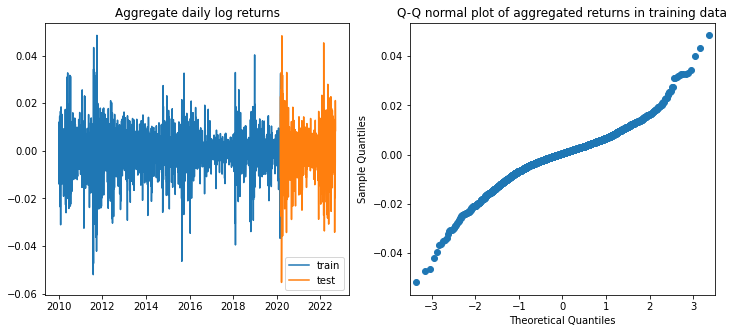

In [27]:
train_agg_ret = all_agg[all_agg['train']]['log_ret']
print('Augmented Dickey-Fuller test for non-stationarity on training data: p-value = %1.5f' \
      % adfuller(train_agg_ret,autolag='AIC')[1])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_agg_ret, label='train')
ax1.plot(all_agg[np.logical_not(all_agg['train'])]['log_ret'], label='test')
ax1.set_title('Aggregate daily log returns')
ax1.legend()
sm.qqplot(train_agg_ret, ax = ax2)
ax2.set_title('Q-Q normal plot of aggregated returns in training data')
plt.show()

**Notes on the distribution of the aggregated daily log returns**
- On the left we see volatility clustering
- On the right we continue to see fat tails, not as pronounced as in the Q-Q plot above
- No clear evidence of non-stationarity looking at the series. This is backed up by the very low p-value from the Augmented Dickey-Fuller test for non-stationarity, applied to the training data.

**Next look at the ACF of the aggregated log returns and squared log returns**

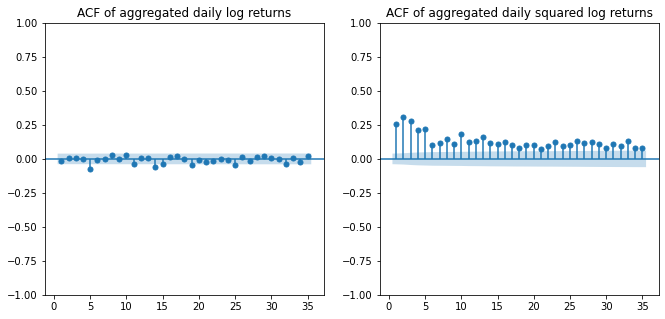

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))
plot_acf(train_agg_ret, ax1, zero = False)
ax1.set_title('ACF of aggregated daily log returns')
plot_acf(train_agg_ret ** 2, ax2, zero = False)
ax2.set_title('ACF of aggregated daily squared log returns')
plt.show()

**Notes**
- The aggregated daily log returns appear to have weak or no serial dependence.
- However, the squared returns appear to have strong serial dependence.
- This suggests the variance of the process is time varying.
- GARCH(1,1) processes are able to model this sort of behavior and capture volatility clustering.

### Fit a GARCH(1,1) model to the aggregated daily returns

In [29]:
am = arch_model(train_agg_ret, vol='Garch', p=1, o=0, q=1, dist='Normal')
res = am.fit(update_freq=5)
print(res.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: -8785.042294530147
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8785.04
Distribution:                  Normal   AIC:                          -17562.1
Method:            Maximum Likelihood   BIC:                          -17538.7
                                        No. Observations:                 2534
Date:                Thu, Nov 09 2023   Df Residuals:                     2533
Time:                        00:42:41   Df Model:                            1
                                  Mean Model                                 
   

**The GARCH(1,1) model appears to capture well the varying volatility in the data!**
- see diagnostic plots below

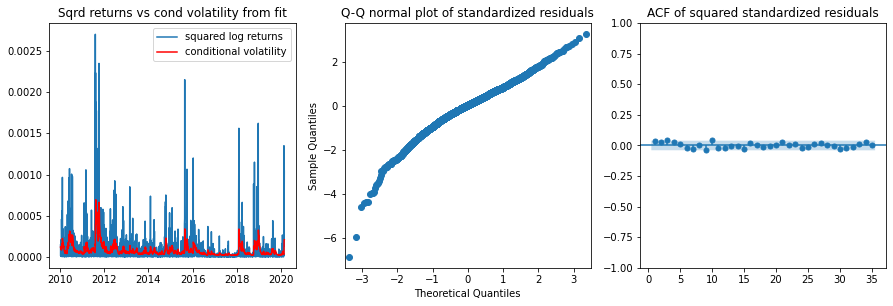

In [30]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4.5))
ax0.plot(train_agg_ret ** 2, label='squared log returns')
ax0.plot(res.conditional_volatility ** 2, label='conditional volatility', color = 'red')
ax0.set_title('Sqrd returns vs cond volatility from fit')
sm.qqplot(res.std_resid, ax = ax1)
ax1.set_title('Q-Q normal plot of standardized residuals')
plot_acf(res.std_resid ** 2, ax2, zero = False)
ax2.set_title('ACF of squared standardized residuals')
ax0.legend()
plt.show()

### Look at returns aggregated over sector
- A GARCH(1,1) model may also capture the volatilility in the returns aggregared over a particular sector.
- The number in in-universe stocks per sector changes over time.
- The sector aggregated returns across the training data share certain volatility patterns but also show differences.
- All sectors 'pass' the Augmented Dickey-Fuller test for non-stationarity on the training data.

In [31]:
# Augmented Dickey-Fuller tests for non-stationarity on the training data
adf_test = [adfuller(sector_agg[sector_agg.train].loc[sect]['log_ret'].dropna(),
                     autolag='AIC')[1] for sect in sectors_list]
print(adf_test)

[0.0, 0.0, 3.1087501089750717e-18, 2.2388911758636214e-26, 3.3580650441615736e-21, 0.0, 2.690374494740747e-19, 0.0, 6.470140256662327e-26, 0.0, 0.0]


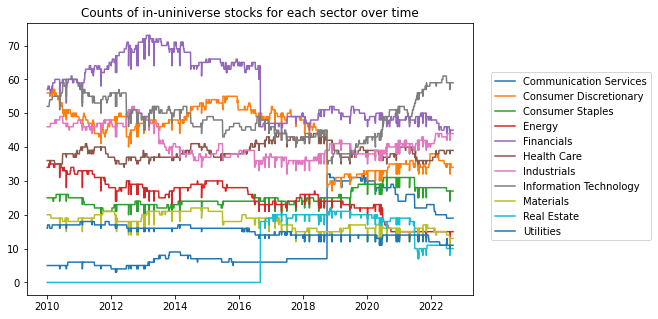

In [32]:
plt.figure(figsize=(8,5))
for sect in sorted(sectors_list):
    plt.plot(sector_agg.loc[sect, 'counts'], label=sect)
    
plt.legend(loc=(1.04, .2))
plt.title('Counts of in-uniniverse stocks for each sector over time')
plt.show()

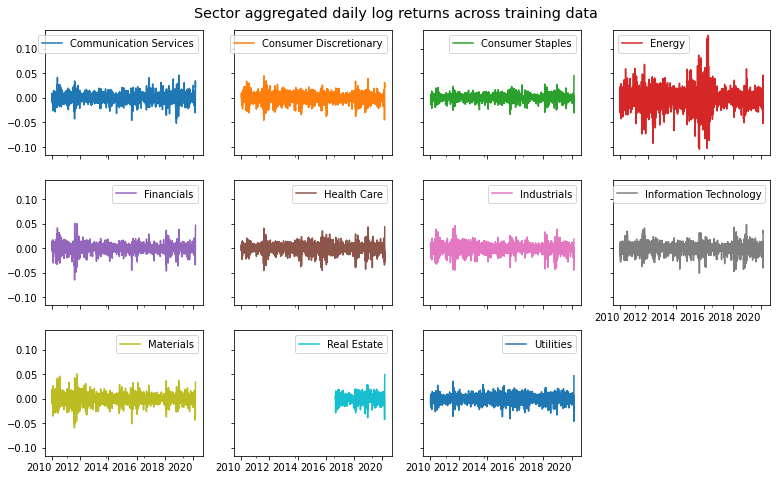

In [33]:
ax = sector_agg[sector_agg.train]['log_ret'].unstack(level=0) \
            .plot(subplots=True, rot=0, figsize=(13, 8), layout=(3, 4), sharey = True)
plt.suptitle('Sector aggregated daily log returns across training data', size = 'x-large')
plt.subplots_adjust(top=.94)
plt.show()

### Fit GARCH(1,1) models to the aggregated returns by sector in the training data

In [34]:
# function for fitting GARCH(1,1) model to the aggregated returns for each sector
# using the given window_dts for training
# returns 1-day ahead volatility and mean return forecasts if forecast is True
# if sector fit does not converge or produces wacky estimate for mean return,
        # use overall aggregated fit on same training data instead
def fit_garch_models_sect(window_dts, forecast, start_params = None):
    cond_volatilities, params, var_forecasts, mean_forecasts = [], [], {}, {}
    
    # fit on full aggregated data to use if issue with particular sector fit
    agg_ret_train = all_agg.loc[window_dts, 'log_ret'].dropna()
    am = arch_model(agg_ret_train, vol='Garch', p=1, o=0, q=1, dist='Normal')
    res_agg = am.fit(update_freq=0, disp=0)
    
    for i, sect in enumerate(sectors_list):
        sect_agg_ret_train = sector_agg.loc[sect, 'log_ret'].loc[window_dts].dropna()
        am = arch_model(sect_agg_ret_train, vol='Garch', p=1, o=0, q=1, dist='Normal')
        
        if start_params is None:
            res_sect = am.fit(update_freq=0, disp=0)
        else:
            res_sect = am.fit(update_freq=0, disp=0, starting_values = start_params[i][0:4])
        
        # check whether there is issue with sector fit and proceed accordingly
        # set flag for whether aggregated fit is used
        use_agg = 0
        if (res_sect.optimization_result['status'] != 0) or (np.abs(res_sect.params['mu']) > .002):
            use_agg = 1
            res_sect = res_agg
        
        params.append(res_sect.params.rename(sect))
        params[i]['use_agg'] = use_agg
        
        # conditional volatility = square root of conditional variance
        cond_volatilities.append(res_sect.conditional_volatility.rename(sect))
        
        # create 1-day ahead 1-day ahead volatility and mean forecasts if forecast is True
        if forecast:
            forecasts = res_sect.forecast(horizon=1)
            var_forecasts[sect] = forecasts.variance.iloc[-1].values[0]
            mean_forecasts[sect] = forecasts.mean.iloc[-1].values[0]
        
    params.append(res_agg.params.rename('all'))  
    params[i + 1]['use_agg'] = np.nan
        
    if forecast:
        return cond_volatilities, var_forecasts, mean_forecasts, params
    else:
        return cond_volatilities, params

Check that all the sector fits converge and look reasonable: True


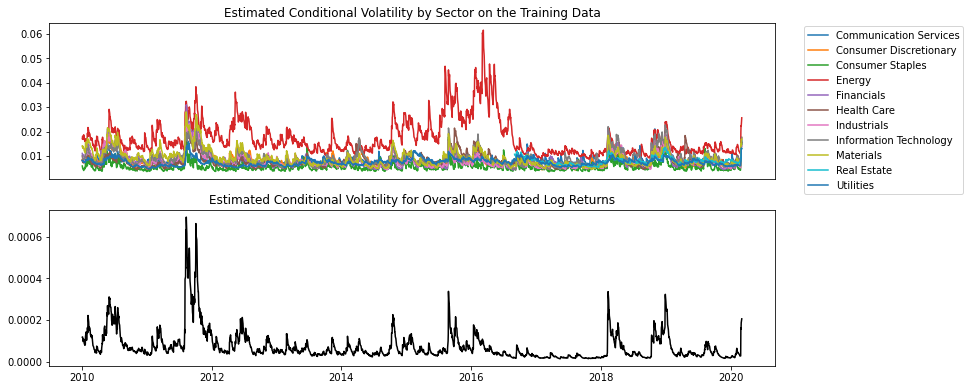

In [55]:
train_dts = sector.index[:TRAIN_CUTOFF + 1]
train_cond_volatilities, train_params = fit_garch_models_sect(train_dts, forecast = False)
train_cond_vol_df = pd.concat(train_cond_volatilities, axis = 1)
print('Check that all the sector fits converge and look reasonable: %s' \
      % str(sum([train_params[0]['use_agg'] for i in range(len(sectors_list))]) == 0))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 10))
train_cond_vol_df.plot(figsize=(13, 7), ax = ax1)
ax1.set_title('Estimated Conditional Volatility by Sector on the Training Data')
ax1.legend(loc=(1.04, -.1))
ax1.set_xticks([])
ax2.plot(res.conditional_volatility ** 2, label='conditional volatility', color = 'black')
ax2.set_title('Estimated Conditional Volatility for Overall Aggregated Log Returns')
plt.show()

## Design a prediction model

### Modeling volatility in the daily log returns

- As the volatility patterns of aggregated sector returns mirrors some of the volatility patterns of the overall aggregated returns, I believe the volatility patterns of the returns of individuals stocks may mirror the volatility patterns of their sectors
- This motivates my approach for modeling individual stock volatility. In particular I create a model based on the assumption that a given stock return's volatility is proportional to the volatility of the aggregated return across its sector.
- Let $r_{i,t}$ be the daily log return of stock $i$ on day $t$.
- Let $c_{j,t}$ be the daily aggregated log return for sector $j$ on day $t$.
- Let $s(i, t) \in \{0,...,10\}$ be the sector for stock $i$ at time $t$. **Note:** stock $i$'s sector can change so that $s(i, t)$ is not constant over time.
- Let $w_i$ be stock $i$'s volatility proportionality weight.
- The key assumption is:


$$ \text{stock $i$'s sector volatility} \approx w_i * \text{stock $i$'s volatility}\,\, \Longleftrightarrow\,\, \text{Var}\,c_{s(i,t),\, t} \approx w_i^2 * \text{Var}\,r_{i, t}$$


- Let $\text{cv}_{j,t}$ be the conditional volatility of sector $j$ on day $t$ estimated by fitting the GARCH(1,1) model
- Define stock $i$'s adjusted returns on day $t$ as 
$$r^{\text{adj}}_{i,t} = \frac{r_{i,t}}{\text{cv}_{s(i, t),t}}$$
- Then
$$\text{Var}\,r^{\text{adj}}_{i,t} \approx \frac{1}{w_i ^ 2}$$
- Estimate the squared weights $w_i^2$ using the sample variances of the adjusted returns.

**Advantages of this approach:**
- Estimating a GARCH(1,1) model separately for each stock does not take advantage of the shared volatility patterns.
- Moreover, stocks come in and out of the universe and this makes estimating individual stock volatility separately much more difficult
- With this approach we get a volatility estimate for each $(i,t)$ stock-date pair in the training data.
- Using forecasts from the estimated sector-aggregated GARCH(1,1) models, we can establish forecasts for the volatility of indidual stocks. For a $k$-day ahead forecast and with a final training date $T$, we have

$$\hat{\text{Var}}\,r_{i, \, T + k} = \frac{\hat{\text{Var}}\,c_{s(i, T + k),\, T + k}}{\hat{w_i}^2}$$

- Fitting GARCH(1,1) models to aggregated returns has advantages in stability and computational complexity.
- And these advantages become more pronounced when making the rolling window, 1-day look ahead predictions below.
- Dividing by aggregated conditional volatility dampens the effect of market volatility in the adjusted returns.  Working with the adjusted returns should help mitigate MARKET exposure.

**Disadvantages of this approach:**
- The principal disadvantage is that a given stock return's volatility is not always proportional to the volatility of the aggregated returns across its sector (that is, the model's central assumption is too strong).

### Calculate the adjusted returns and volatility proportionality weights on the training data:

**Note:**
- Splitting `all_stocks_df` into a list of dfs, `stocks_df_list`, one for each stock, helps a lot with the runtime here and for the `get_pred` function below

In [36]:
stocks_df_list = [all_stocks_df.loc[i] for i in range(NUM_STOCKS)]
cond_vol_array = np.array(train_cond_vol_df)

wgts, train_dfs = [], []
stocks_ids_train = all_stocks_df[all_stocks_df.train]['stock_id'].unique()

for stock_id in stocks_ids_train:
    # retrieve returns data for stock i in training period
    train_df = stocks_df_list[stock_id][stocks_df_list[stock_id].train]
    # get the corresponding conditional volatilities from the GARCH(1,1) sector fits
    cv = np.take(cond_vol_array, train_df['row_ind'] * num_sectors + train_df['sector_id'])
    # computed adjusted returns
    log_ret_adj = train_df['log_ret_intraday'].values / cv
    # estimate stock i's weight
    wgt = 1 / np.var(log_ret_adj)
    wgts.append(wgt)
    # store output
    train_df['log_ret_adj'] = log_ret_adj
    train_df['next_log_ret_adj'] = train_df['log_ret_adj'].shift(-1)
    train_df['wgt'] = wgt
    train_dfs.append(train_df)

# concatenate output across all training stocks
df_fit = pd.concat(train_dfs, keys=stocks_ids_train, names = ('stock_id', 'date'))

### Examine the results
- Check that the sample variance of $w_i * r^{\text{adj}}_{i,t}$ calculated across all $i,t$ is close to 1.
- Comparing the distribution of the weighted adjusted returns $w_i * r^{\text{adj}}_{i,t}$ to the distribution of the unadjusted log returns $r_{i,t}$, we see improvement in the tails, but still not close to normal

Check sample variance of weighted adjusted returns: 1.001474


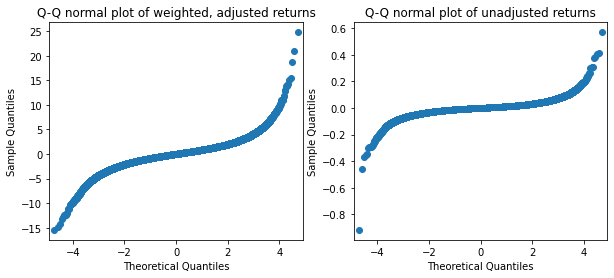

In [37]:
print('Check sample variance of weighted adjusted returns: %1.6f' \
            % np.var(df_fit['log_ret_adj'] * np.sqrt(df_fit['wgt'])))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sm.qqplot(df_fit['log_ret_adj'] * np.sqrt(df_fit['wgt']), ax = ax1)
ax1.set_title('Q-Q normal plot of weighted, adjusted returns')
sm.qqplot(df_fit['log_ret_intraday'], ax = ax2)
ax2.set_title('Q-Q normal plot of unadjusted returns')
plt.show()

### Capturing volatility for individual stocks
- Compare the unadjusted returns to the adjusted returns for individual stocks.
- Compare the serial dependence in the squared returns.
- For stock 32 the model captures and adjusts for the volatility clustering.
- For stock 58, there remains some serial dependence in the adjusted returns. 

In [38]:
def examine_vol_fit(train_stock_ind):
    stock_id = stocks_ids_train[train_stock_ind]
    print('Sector information:')
    print(df_fit.loc[stock_id, 'sector'].value_counts())
    
    log_ret = df_fit.loc[stock_id, 'log_ret_intraday']
    log_ret_adj = df_fit.loc[stock_id, 'log_ret_adj']
    
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16, 4))
    ax0.plot(log_ret)
    ax0.set_title('unadjusted returns')
    plot_acf(log_ret ** 2, ax1, zero = False)
    ax1.set_title('ACF of sqrd unadjusted returns')
    ax2.plot(log_ret_adj)
    ax2.set_title('adjusted returns')
    plot_acf(log_ret_adj ** 2, ax3, zero = False)
    ax3.set_title('ACF of sqrd adjusted returns')
    
    plt.subplots_adjust(top = 0.85)
    plt.suptitle('Stock i=%1d with weight=%2.4f, T = %2d' \
                 % (stock_id, wgts[train_stock_ind], len(log_ret)), size='x-large')
    plt.show()

Sector information:
Financials    2534
Name: sector, dtype: int64


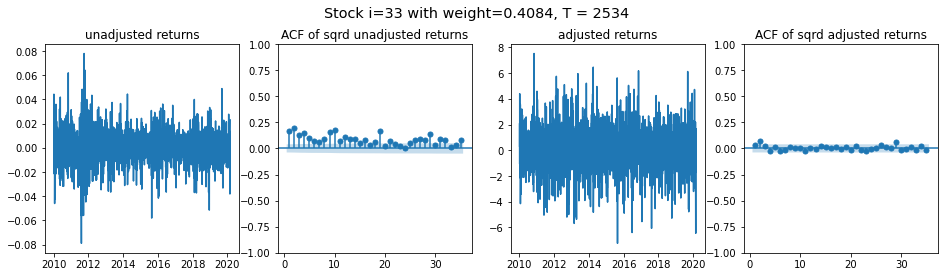

In [39]:
examine_vol_fit(30)

Sector information:
Energy    2534
Name: sector, dtype: int64


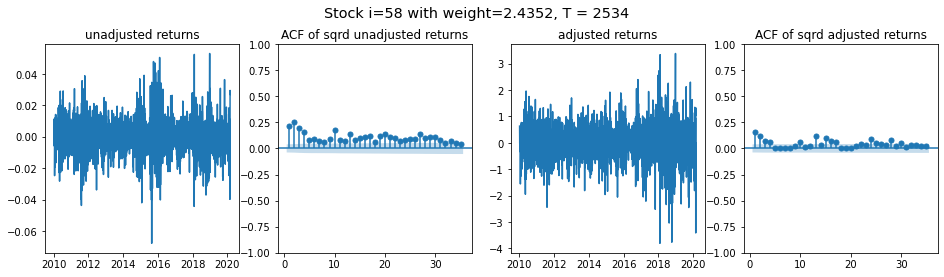

In [40]:
examine_vol_fit(55)

### Examine the estimated weights $\hat{w_i}$
- See plots below!
- The fitted weights exhibit right skew.
- The fitted weights generally have an inverse relationship with the size (price and market cap) and liquidity (average daily volume) of the stock.
- **This suggests that the weights might be sucessfully used avoid a prediction model that favors small, illiquid stocks that are much more expensive to trade.**

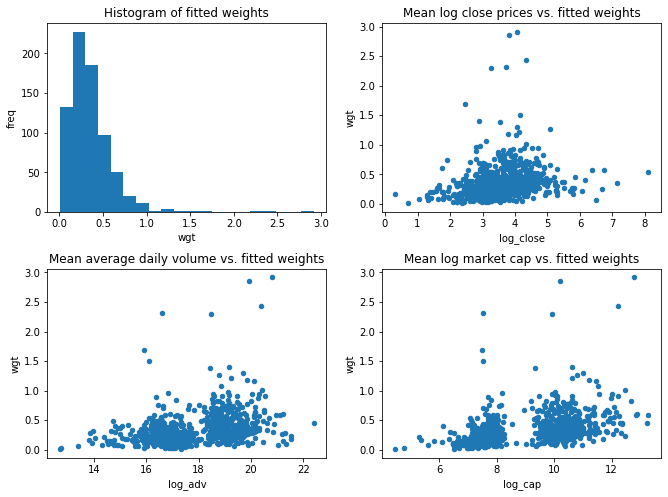

In [41]:
train_stocks_sum = df_fit.drop('stock_id', axis = 1) \
    .groupby('stock_id')['log_cap', 'log_close', 'log_adv', 'wgt'].mean()

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(11, 8))
ax0.hist(wgts, bins = 20)
ax0.set_title('Histogram of fitted weights')
ax0.set_xlabel('wgt')
ax0.set_ylabel('freq')

train_stocks_sum.plot.scatter('log_close', 'wgt', ax = ax1)
ax1.set_title('Mean log close prices vs. fitted weights')
train_stocks_sum.plot.scatter('log_adv', 'wgt', ax = ax2)
ax2.set_title('Mean average daily volume vs. fitted weights')
train_stocks_sum.plot.scatter('log_cap', 'wgt', ax = ax3)
ax3.set_title('Mean log market cap vs. fitted weights')

plt.subplots_adjust(hspace=.3)
plt.show()

## Weighted Least Squares Model for Adjusted Returns 

- I fit the following linear model for next-day adjusted returns using the fitted weights

$$r^{\text{adj}}_{i,t} = \beta_0 \,+\, \beta_1\,\text{log_adv}_{i,t-1} \,+\, \beta_2\,\text{tech_ind}_{i,t-1} \,+\, \beta_3\,\text{inc_q_abs_lg_adj}_{i,t-1} \,+\, \epsilon_{i,t}$$

$$\epsilon_{i,t} \sim \text{N}(0, \hat{w_i}^2)$$

- $\text{log_adv}_{i,t}$ is the logarithm of stock $i$'s average daily volume in dollars on day $t$
- $\text{tech_ind}_{i,t}$ is the technical indicator for stock $i$ on day $t$
- $\text{inc_q_abs_lg_adj}_{i,t}$ is the time-discounted, adjusted quarterly net income from the financial indicator data, calculated as:
$$\text{inc_q_abs_lg_adj}_{i,t} = f(\text{qrtly net income from stock $i$'s most recent statement before time $t$}) \times e^{-.02\, \times\, \text{days between t and statement}}$$
$$\text{where } f(x) = \begin{cases}
  \text{sign}(x) \log |x|  &|x| > 1 \\
  0 &|x| \leq 1
\end{cases}$$

**Note:**
- To fit this model, I restrict the training data to the 523,783 out of 853,503 training rows where all the predictors are available.

In [42]:
fit_rows = np.sum(np.isnan(np.array(df_fit[['next_log_ret_adj', 'log_adv', 'inc_q_abs_lg_adj', 'tech_ind']])),
                  axis=1) == 0
wls_model = wls('next_log_ret_adj ~ log_adv + inc_q_abs_lg_adj + tech_ind',
                 data = df_fit, subset = fit_rows, weights = df_fit[fit_rows]['wgt'].values)
wls_result = wls_model.fit()
print("Model R-squared: %1.6f" % wls_result.rsquared)
print(wls_result.scale)
wls_result.summary()

Model R-squared: 0.000132
1.0012645541710852


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:       next_log_ret_adj   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     23.09
Date:                Thu, 09 Nov 2023   Prob (F-statistic):           6.17e-15
Time:                        00:42:51   Log-Likelihood:            -9.9516e+05
No. Observations:              523783   AIC:                         1.990e+06
Df Residuals:                  523779   BIC:                         1.990e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2324      0.033      7.087      0.000       0.168       0.297
log_adv             -0.0111      0.002     -6.619      0.000      -0.014      -0.008
inc_q_abs_lg_adj     0.0051      0.001      5.088      0.000       0.003       0.007
tech_ind            -0.0361      0.009     -3.917      0.000      -0.054      -0.018
==============================================================================
Omnibus:                    59554.272   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           555706.604
Skew:                          -0.149   Prob(JB):                         0.00
Kurtosis:                       8.037   Cond. No.                         309.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Notes on fit
- With an $R^2 = 0.000132$ the model captures *very* little of the variance in the the next day adjusted log returns.
- The coefficients for my selected covarariates are all significant under the models normality assumption.
- This is not a very good predictive model. But hopefully it is capturing some of the signal in the data. I note that the signal-to-noise ratio for predicting next day returns seems quite small, making it a difficult task.

## Make predictions on test data

- I proceed with this WLS model for adjusted returns along with the GARCH(1,1) sector-aggregated volatility model in order to make 1-day look ahead predictions on the test data.
    - When a prediction cannot be made with the WLS model because of missing covariates, I use the stock's sector forecast for mean log return (the fitted GARCH(1,1) model incorporates a constant mean component)
- For each testing date, I refit each aggregated volatility model and then the WLS model based on a rolling window of training data.
- I perform the predictions with window sizes 100, 200, 365 and 500.
- **Note:** ConvergenceWarnings and certain wacky estimates are handled in the fit_garch_models_sect()

In [43]:
# function for getting a prediction for all in-universe stocks at the given testing index
# using the training data in the window of specified size immediatedly preceeding the test date
def get_pred(test_ind, window):
    
    overall_ind = TRAIN_CUTOFF + test_ind
    test_dt = sector.index[overall_ind]
    window_dts = sector.index[overall_ind - window:overall_ind]
    
    first_dt, last_dt = window_dts[0], window_dts[-1]
    
    ## FIT GARCH(1,1) TO AGGREGATED SECTOR DATA
    # use garch estimates from train data as starting param values
    # this can help with convergence and help avoid wacky estimates
    cond_vols, var_forecasts, mean_forecasts, params = fit_garch_models_sect(window_dts, True, train_params)
    cond_vol_array = np.transpose(np.array(cond_vols))
    
    ## CALCULATE THE ADJUSTED RETURNS AND WEIGHTS
    var_preds, mean_preds, wgts, window_dfs = [], [], [], []
    # restrict to the in-universe stocks for the given testing date
    stock_sect_pred = all_stocks_df.loc[(slice(None), test_dt), ('sector', 'log_ret_intraday')]
    stock_ids = list(stock_sect_pred.droplevel('date').index)
    for stock_id in stock_ids:
        # retrieve returns data for stock i in training window
        l = np.searchsorted(stocks_df_list[stock_id].index, first_dt, side='left')
        r = np.searchsorted(stocks_df_list[stock_id].index, last_dt, side='right')
        window_df = stocks_df_list[stock_id].iloc[l:r]
        
        # get the corresponding conditional volatilities from the GARCH(1,1) sector fits
        cv = np.take(cond_vol_array, (window_df['row_ind'] - sector.index.get_loc(first_dt)) \
                                         * num_sectors + window_df['sector_id'])
        # computed adjusted returns
        log_ret_adj = window_df['log_ret_intraday'].values / cv
        # estimate stock i's weight
        wgt = 1 / np.var(log_ret_adj)
        wgts.append(wgt)

        # store output
        window_df['log_ret_adj'] = log_ret_adj
        window_df['next_log_ret_adj'] = window_df['log_ret_adj'].shift(-1)
        window_df['wgt'] = wgt
        window_dfs.append(window_df)
        
        # get the relevant forecasts from the GARCH(1,1) sector fits
        var_preds.append(var_forecasts[stock_sect_pred.loc[stock_id, 'sector'].values[0]])
        mean_preds.append(mean_forecasts[stock_sect_pred.loc[stock_id, 'sector'].values[0]])
    
    ## CONCATENATE OUPUT AND FIT WLS MODEL
    df_fit = pd.concat(window_dfs, keys=stock_ids, names = ('stock_id', 'date'))
    fit_rows = np.sum(np.isnan(np.array(df_fit[['next_log_ret_adj', 'log_adv', 'inc_q_abs_lg_adj', 'tech_ind']])),
                      axis=1) == 0
    wls_model = wls('next_log_ret_adj ~ log_adv + inc_q_abs_lg_adj + tech_ind',
                     data = df_fit, subset = fit_rows, weights = df_fit[fit_rows]['wgt'].values)
    wls_result = wls_model.fit()

    ## CREATE PREDICTION OUTPUT
    stock_sect_pred['wgt'] = wgts
    # compute the forecasts for the volatility of indidual stocks
    stock_sect_pred['var_pred'] = np.array(var_preds) / np.array(wgts)
    # store GARCH(1,1) forecasts for log return (constant mean model)
    stock_sect_pred['mean_pred'] = mean_preds
    # get test rows from df_fit with WLS covariates
    test_rows = df_fit[df_fit.date == last_dt].droplevel('date')
    # determine which rows can be predicted with wls_model (where covariates not missing)
    pred_rows = np.sum(np.isnan(np.array(test_rows[['log_adv', 'inc_q_abs_lg_adj', 'tech_ind']])),
                      axis=1) == 0
    # merge on adjusted log return predictions from wls_model to test rows
    pred_df = stock_sect_pred.merge(wls_result.predict(test_rows[pred_rows]).rename('pred_adj'),
                                    how='left', left_on='stock_id', right_index=True)
    # if a prediction cannot be made with wls_model, use the GARCH(1,1) sector forecasts for log return
    # otherwise `unadjust' the adjusted return forcast with the GARCH(1,1) sector forecast for volatility
    pred_df['pred'] = np.where(np.isnan(pred_df['pred_adj']),
                               stock_sect_pred['mean_pred'],
                               pred_df['pred_adj'] * np.sqrt(var_preds))
    # calculated standardized residual
    pred_df['resid_std'] = (pred_df['log_ret_intraday'] - pred_df['pred']) / np.sqrt(pred_df['var_pred'])
    pred_df['window'] = window
    
    ## wrangle the estimated GARCH(1,1) model parameters
    param_series = pd.concat(params, keys = list(sectors_list) + ['all'], axis = 0,
                              names = ['sector', 'param']).rename(test_dt)
    
    return pred_df, param_series

In [44]:
## function to run one-day ahead predictions in parallel for a given window size
def run_preds(num_inds, window):
    pool = mp.Pool(N_CORES_USE)
    pred_out = pool.starmap_async(get_pred,
                                  [(i + 1, window) for i in range(num_inds)])
    pred_list, param_list, dts = [], [], []
    for pred_df, param_series in pred_out.get():
        pred_list.append(pred_df)
        param_list.append(param_series)
        dts.append(param_series.name)
        
    param_series = pd.concat(param_list, keys = dts, names = ['date', 'sector', 'param'])
    filter_rows = param_series.index.get_level_values(2) == 'use_agg'
    param_df = pd.merge(param_series[np.logical_not(filter_rows)].rename('values'),
                        param_series[filter_rows].droplevel(2).rename('use_agg'),
                        on = ('date', 'sector'))

    param_df['param'] = param_series.index.get_level_values(2)[np.logical_not(filter_rows)]
    param_df['window'] = window
    param_df['values'] = np.where(param_df['use_agg'] == 1, np.nan, param_df['values'])

    return pd.concat(pred_list), param_df

In [45]:
## function for summarizing the prediction results
def summarize_pred_df(pred_df, window):
    pred_df['sqrd_err'] = (pred_df['log_ret_intraday'] - pred_df['pred']) ** 2
    pred_df['sqrd_log_ret'] = pred_df['log_ret_intraday'] ** 2
    pred_df['rel_sqrd_err'] = pred_df['sqrd_log_ret'] - pred_df['sqrd_err']
    pred_df['vol_chk95'] = np.logical_and(
        pred_df['log_ret_intraday'] < pred_df['pred'] + 1.96 * np.sqrt(pred_df['var_pred']),
        pred_df['log_ret_intraday'] > pred_df['pred'] - 1.96 * np.sqrt(pred_df['var_pred'])
    )
    pred_df['vol_chk50'] = np.logical_and(
        pred_df['log_ret_intraday'] < pred_df['pred'] + .6745 * np.sqrt(pred_df['var_pred']),
        pred_df['log_ret_intraday'] > pred_df['pred'] - .6745 * np.sqrt(pred_df['var_pred'])
    )
    pred_df['sign_chk'] = np.sign(pred_df['log_ret_intraday']) == np.sign(pred_df['pred'])

    measures = ['sqrd_err', 'sqrd_log_ret', 'rel_sqrd_err', 'sign_chk', 'vol_chk95', 'vol_chk50']
    results_stock = pred_df[measures].groupby(['stock_id']).mean()
    results_stock['count'] = pred_df.index.get_level_values(0).value_counts().rename('counts').sort_index()
    results_stock['window'] = window
    results_sector = pred_df[measures + ['sector']].groupby(['sector']).mean()
    results_sector['count'] = pred_df['sector'].value_counts().sort_index()
    results_overall = pred_df[measures].mean()
    results_overall['count'] = pred_df.shape[0]
    results_sector.loc['overall'] = results_overall
    results_sector['window'] = window
    
    return results_stock, results_sector

In [46]:
## function for running predictions for all the testing dates, using the given window size
def run_window(window):
    pred_df, params_df = run_preds(N_TEST, window)
    sum_stocks, sum_sector = summarize_pred_df(pred_df, window)
    return pred_df, params_df, sum_stocks, sum_sector

In [47]:
pred_100, params_100, stocks_100, sector_100 = run_window(100)
pred_200, params_200, stocks_200, sector_200 = run_window(200)
pred_365, params_365, stocks_365, sector_365 = run_window(365)
pred_500, params_500, stocks_500, sector_500 = run_window(500)

/Users/williamreedpalmer/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/Users/williamreedpalmer/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/Users/williamreedpalmer/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,
/Users/williamreedpalmer/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompati

## Prediction results

### Look at overall results across the varying window sizes
- **The WLS model has poor predictive performance for next day returns** 
    - Plot (a) below shows the mean squared prediction error decreasing with window size
    - However, the predictions for all window sizes are worse (in MSE) in than if one were to always predict zero for the next day's return. In that case the MSE would be the mean of the squared returns, shown with the orange line.
    - Plot (b) shows the rate of sign agreement between the predicted returns and the actual returns in the test data. That is, how often does the model correctly predict a positive or negative daily return.
    - This rate remains slightly lower than .5 for all windows. A coin flip might perform better.
- **On the other hand, the volatility model seems to perform well** 
    - Plot (c) shows the percentage of predictions for which the actual return falls in the forecasted 95% confidence interval (built with normality assumption) for the next day return.
    - We want to see a rate near 95% here, and the rates are only slightly below, just above 94.5% when the window size is 500. This indicates that the model is forecasting slightly less volatility in the tails than the actual returns show.
    - Plot (d) shows the percentage of predictions for which the actual return falls in the forecasted 50% confidence interval (again built with normality assumption).
    - We see rates around 55-56%, above the 50% target. This indicates that the model is forecasting more volatility in the middle of the distribution what the actual returns show.
    - **Note** Constructing intervals with a Student's t-distribution might improve the alignment here.

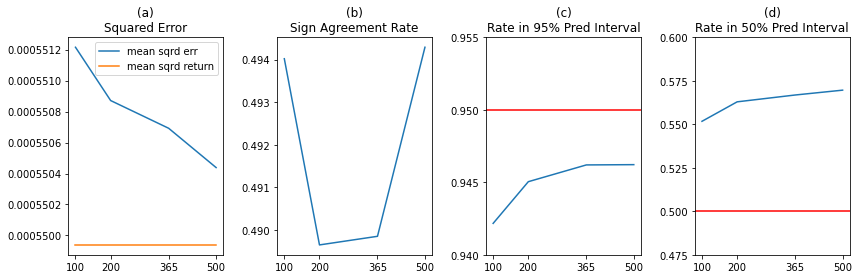

In [48]:
windows = [100,200,365,500]
overall_results = pd.concat([sector_100.loc['overall'].rename(100),
                             sector_200.loc['overall'].rename(200),
                             sector_365.loc['overall'].rename(365),
                             sector_500.loc['overall'].rename(500)],
                            axis = 0, keys = windows, names = ('window', 'measure'))

measures = ['sqrd_err', 'sign_chk', 'vol_chk95', 'vol_chk50']
plot_titles = ['(a)\nSquared Error', '(b)\nSign Agreement Rate',
               '(c)\nRate in 95% Pred Interval', '(d)\nRate in 50% Pred Interval']
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(14, 4))
ax_list = [ax0, ax1, ax2, ax3]
for i, measure in enumerate(measures):
    ax_list[i].plot(overall_results[overall_results.index.get_level_values(1) == measure].droplevel(1),
                    label = 'mean sqrd err')
    ax_list[i].set_xticks(windows)
    ax_list[i].set_title(plot_titles[i])
    
ax0.plot(overall_results[overall_results.index.get_level_values(1) == 'sqrd_log_ret'].droplevel(1),
        label = 'mean sqrd return')    
ax0.legend()
ax2.axhline(y = 0.95, color = 'r', linestyle = '-') 
ax2.set_yticks(np.arange(.94, .955, step=0.005))
ax3.axhline(y = 0.5, color = 'r', linestyle = '-') 
ax3.set_yticks(np.arange(.475, .61, step=0.025))
plt.subplots_adjust(wspace=.35)
plt.show()

### Look at relative predictive performance across the stocks in testing data
- Let the relative squared error (rel sqrd err) be the difference between a prediction's squared error and the square of the log return being predicted
- This measures a given prediction model agaist the null prediction model, under which one predicts zero for all log returns.
- Using this measure I can get some sense of which stocks my prediction model predicts relatively better or relatively worse.
- Since all my predictions are very close to zero, the differences here are small.
- The plots below compare the mean relative squared errors across the predicted stocks.
- The results here do not say much. However, they provide no strong evidence of SIZE exposure. My prediction model does not favor small or illiquid stocks that are expensive to trade. In fact there is slight evidence that the model performs relatively better on stocks with large average daily volume (bottom left plot).
- **Note:** here and below I restrict my attention to prediction results with window size of 500 

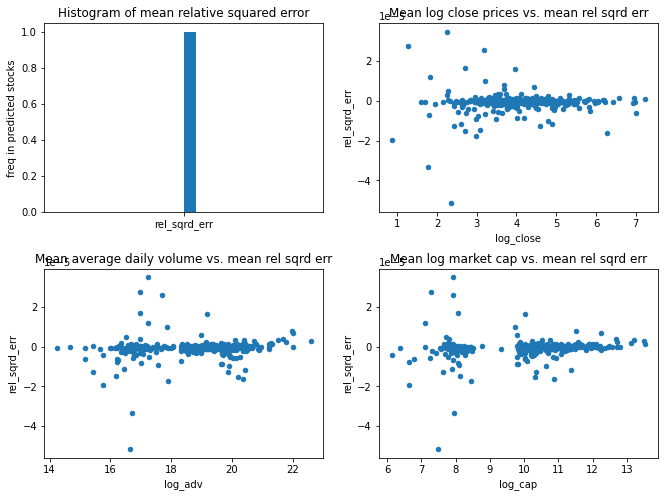

In [49]:
test_stocks_sum = all_stocks_df.drop('stock_id', axis = 1) \
    .groupby('stock_id')['log_cap', 'log_close', 'log_adv'].mean() \
    .merge(stocks_500, how = 'right', on = 'stock_id')

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(11, 8))
ax0.hist('rel_sqrd_err', bins = 20)
ax0.set_title('Histogram of mean relative squared error')
#mean sqrd return - mean sqrd error
#ax0.set_xlabel('relative predictive performace')
ax0.set_ylabel('freq in predicted stocks')

test_stocks_sum.plot.scatter('log_close', 'rel_sqrd_err', ax = ax1)
ax1.set_title('Mean log close prices vs. mean rel sqrd err')
test_stocks_sum.plot.scatter('log_adv', 'rel_sqrd_err', ax = ax2)
ax2.set_title('Mean average daily volume vs. mean rel sqrd err')
test_stocks_sum.plot.scatter('log_cap', 'rel_sqrd_err', ax = ax3)
ax3.set_title('Mean log market cap vs. mean rel sqrd err')

plt.subplots_adjust(hspace=.3)
plt.show()

### Look at prediction results for individual stocks
- The plots below show a given stock's log returns in the testing data along with my forecasts
- My predictions are all very close to zero and do not provide much to bet on.
- However, the forecasted volatility looks pretty good!
- I examine the standardized residuals from my forecats:
$$\text{std resid}_{i,\,T + 1} = \frac{r_{i,\,T + 1} - \hat{r_{i,\,T + 1}}}{\sqrt{\hat{\text{Var}\,r_{i, \, T + 1}}}}$$
- I can see that my forecasting has successfully captured some of the volatility clustering in the testing data. The strong serial dependence in the squared returns is not as present for the squared standardized residuals.

In [50]:
def look_at_preds(pred_df, test_stock_ind, window):
    stocks_ids_test = pred_df.index.get_level_values(0).unique()
    stock_id = stocks_ids_test[test_stock_ind]
    
    df = pred_df.loc[stock_id]
    print('Sector information:')
    print(df['sector'].value_counts())
    
    #df = df[(df.index < '2020-10-04') & (df.index > '2020-06-04')]
    plt.figure(figsize=(12,5))
    plt.plot(df['log_ret_intraday'], color = 'red', label='true return')
    plt.plot(df['pred'], label='predicted return')
    plt.fill_between(df.index, df['pred'] - 1.96 * np.sqrt(df['var_pred']),
                               df['pred'] + 1.96 * np.sqrt(df['var_pred']),
                     color = "grey", alpha=0.2, label = "+/- 1.96 * forcasted volatility ")
    plt.fill_between(df.index, df['pred'] - np.sqrt(df['var_pred']),
                               df['pred'] + np.sqrt(df['var_pred']),
                     alpha=0.2, label = "+/- 1 * forcasted volatility")
    plt.legend()
    plt.title('Log returns for stock %1d on test data with predictions (T = %2d)\nwindow size = %3d' \
                  % (stock_id, df.shape[0], window),
             size='x-large')
    plt.show()

    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(12, 4.5))
    plot_acf(df['log_ret_intraday'] ** 2, ax0, zero = False)
    ax0.set_title('ACF of sqrd log returns in test data')

    ax1.plot(df['resid_std'])
    ax1.set_title('Std residuals from prediction model')
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval = 12))

    plot_acf(df['resid_std'] ** 2, ax2, zero = False)
    ax2.set_title('ACF of sqrd std residuals')
    plt.show()

Sector information:
Health Care    633
Name: sector, dtype: int64


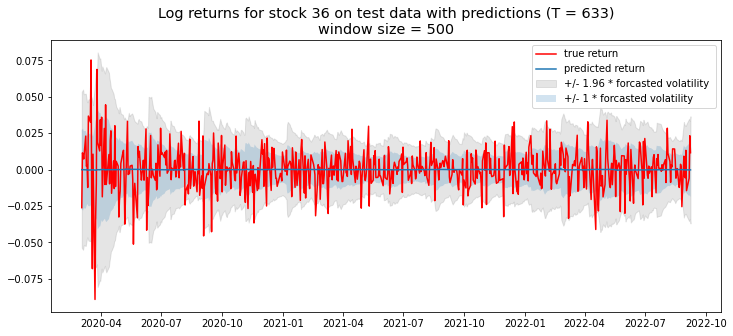

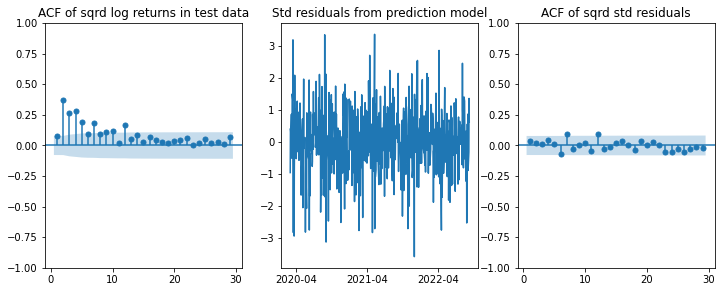

In [51]:
look_at_preds(pred_500, 21, 500)

Sector information:
Industrials    298
Name: sector, dtype: int64


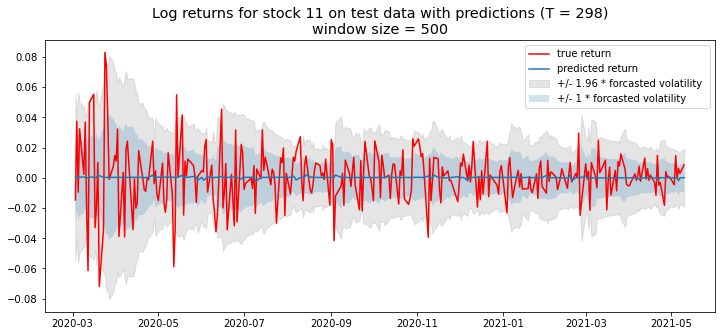

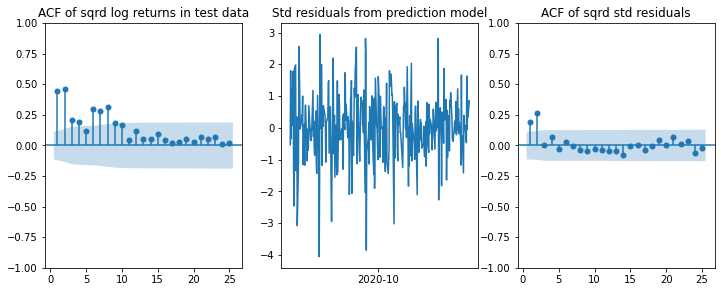

In [52]:
look_at_preds(pred_500, 4, 500)

### Look at how the GARCH(1,1) parameter estimates vary over time

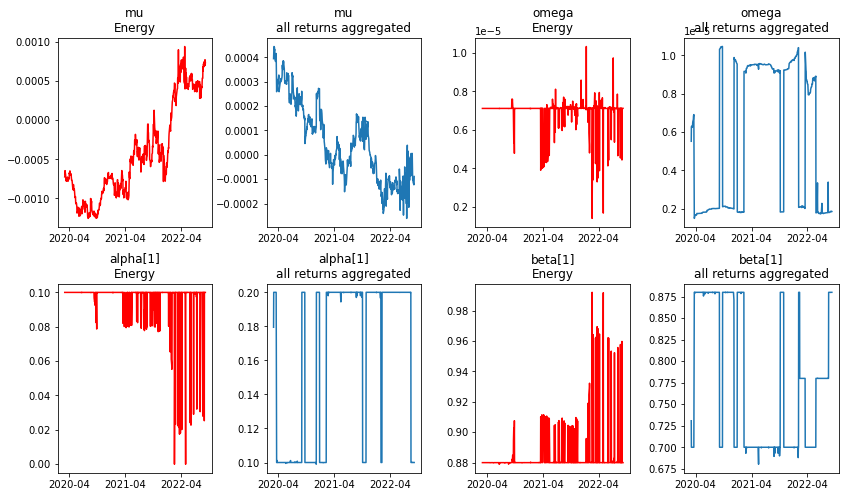

In [53]:
params_df = params_500
params = params_df['param'].unique()

def plot_param_estimates(params_df, sect):
    params = params_df['param'].unique()
    
    fig, ((ax0, ax0r, ax1, ax1r), (ax2, ax2r, ax3, ax3r)) = plt.subplots(2, 4, figsize=(14, 8))
    ax_list = [ax0, ax1, ax2, ax3]
    ax_list_r = [ax0r, ax1r, ax2r, ax3r]
    #for sect in sectors_list:
    for i, param in enumerate(params):
        vals = params_df['values'][(params_df.index.get_level_values('sector') == sect) \
                                   & (params_df['param'] == param)]
        ax_list[i].plot(vals.droplevel(1), label = sect, color = "red")
        ax_list[i].set_title(param + '\n' + sect)
        ax_list[i].xaxis.set_major_locator(mdates.MonthLocator(interval = 12))
        vals_r = params_df['values'][(params_df.index.get_level_values('sector') == 'all') \
                                     & (params_df['param'] == param)]
        ax_list_r[i].plot(vals_r.droplevel(1), label = 'all')
        ax_list_r[i].set_title(param + '\n' + 'all returns aggregated')
        ax_list_r[i].xaxis.set_major_locator(mdates.MonthLocator(interval = 12))

    plt.subplots_adjust(hspace=.3, wspace=.35)
    plt.show()

plot_param_estimates(params_500, 'Energy')

## Conclusion

Here is the high-level summary of my prediction results using a window size of 500:

In [54]:
print('Number of predictions: %1d' % sector_500.loc['overall', 'count'])
print('Mean squared error for predicting log returns: %1.7f' \
         % sector_500.loc['overall', 'sqrd_err'])
print('Rate at which I correctly predict a positive or negative daily return: %1.4f' \
         % sector_500.loc['overall', 'sign_chk'])
print('Rate at which actual returns falls in the forecasted %s%% confidence intervals: %1.4f' \
         % (95, sector_500.loc['overall', 'vol_chk95']))
print('Rate at which actual returns falls in the forecasted %s%% confidence intervals: %1.4f' \
         % (50, sector_500.loc['overall', 'vol_chk50']))

Number of predictions: 207583
Mean squared error for predicting log returns: 0.0005504
Rate at which I correctly predict a positive or negative daily return: 0.4943
Rate at which actual returns falls in the forecasted 95% confidence intervals: 0.9462
Rate at which actual returns falls in the forecasted 50% confidence intervals: 0.5696


### Summary of prediction model
- I propose a volatilty model for log returns based on GARCH(1,1) models for the aggregated log returns across each sector.
- Fitting this volatility model outputs adjusted log returns and estimated weights for each stock.
- With these adjusted returns and weights I construct and fit a Weighted Least Squares (WLS) model for next day adjusted returns.
    - This model is very weak, with R-squared less than .001 on the training data.
- I make 1-day look ahead predictions on the test data based on a rolling window of training data.
    - For each testing date, I refit each GARCH(1,1) sector-aggregated volatility model, re-estimate the weights and refit the WLS model for the adjusted returns.
    - My predictions are all very close to zero and do not provide much alpha signal to bet on.
    - However, the volatility predictions seem to perform well and are able to capture some of the volatility clustering in the testing data.
   

### Potential future ideas for improving predictions:
- Consider **momentum** trading strategies and measures of stock momentum in my prediction model. I am interested in how momentum measures may be used in conjuction with the holding data. In a model that considers momentum I may be able to take better advantage of the technical indicator data.
- Explore using a long short-term memory (**LSTM**) model for prediction, potentially with the adjusted returns.
- Perform further feature engineering and exploration to try and improve the WLS model.
- Explore other models for the adjusted returns that can potentially incorporate the estimated weights.